# Linear Regression


In this notebook, we will show you how to implement linear regression from scratch. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from util import print_result

sns.set()
%matplotlib inline 

## Introduction 

In this chapter, we introduce linear models for regression applications. Linear models are relatively simple models but it is well worth studying linear models due to two main reasons. If the relationship between input features (denoted by $\mathbf{x}$) and response variable (denoted by $\mathbf{y}$) linear models perform better than more advanced machine learning models. Secondly, a firm understanding of linear models will help us to easily grasp more advanced concepts we will study under the non-linear models.

## Let’s Predict Car Price

Let’s start our discussion with a simple real-world example. Assuming you are running a secondhand car showroom. The main object of your business is to sell used cars to potential customers. In order to prevent losing customers and hence, maximizing your profile, it is necessary to assign correct price tag for each car you are selling in your showroom. 
Since you are somewhat familiar with machine learning you are are going to address this problem using linear regression. From your previous experience, you are well aware a price tag of a car depends on several parameters such as mileage, manufacturing year, and engine capacity. For simplicity initially, we assume that price depends only on mileage, manufacturing year. So you collect those data from your previous successful deals and presented as shown in **Table 1**. 

|Mileage ( in 10,000 km )|Manufacturing Year| Price in ( 1000 USD)|
| :------------- |:-------------| :-----|
| 5      | 2010     |5.5  |
| 10     | 2000     |3.1  |
| 12     | 1999     |2.1  |
| 4      | 2012     |5.1  |
| 8      | 2001     |2.1  |
| 7      | 2002     |2.2  |
| 15     | 1997     |0.8  |
| 3      | 2008     |3.5  |
| 6.5    | 2003     |4.0  |
| 3.4    | 2013     |5.1  |

In order to better understand the relationship between car price and manufacturing year, let’s draw a scatter plot.


<p><center>![Basic Tree Terminology](../../images/inkscape/car_prices_scatter.svg)</center></p>
<p><center><b>Figure 1</b>: Distribution of car prices against the manufacturing year.</center></p>

According to our scatter plot, it looks like we can use a straight line to represent the relationship between the manufacturing year and the car price. So if I use $x$ to represent manufacturing year and $y$ is to represent car price we can use $y = w_1*x + w_0$ equation to represent the relationship between the manufacturing year and the car price. However, from your high-school mathematics, you know just two points are enough for drawing a straight line. Hence, we can draw so many lines. Two of those lines are shown in **Figure 2**.

<p><center>![Basic Tree Terminology](../../images/inkscape/possible_lines.svg)</center></p>
<p><center><b>Figure 1</b>: Basic Tree Terminology</center></p>

Now the question is how we can select the best straight line which correctly describes the relationship. In Figure 3 we show one possible straight line. Also, distances between line and the points which are not on the line are denoted by $\Delta$. So the basic idea of the linear regression is to find out a straight line which minimizes the error terms.

<p><center>![Basic Tree Terminology](../../images/inkscape/error_distances.svg)</center></p>
<p><center><b>Figure 1</b>: Basic Tree Terminology</center></p>

So if we consider one particular prediction (denoted by $f(x_n; w_0, w_1)$  and coresponsing actual target value (denoted by $t_n$), the error between actual and predicted values can be contified by:

$$(t_n - f(x_n; w_0, w_1))^2$$

Considering all N data points this can be written as:

$$L(\mathbf{w}) = \frac{1}{N}\sum_{i=1}^N(t_n - f(x_n; w_0, w_1)^2$$

The same thing can be written in matrix notation as given below.

$$L(\mathbf{w}) = \frac{1}{N}(\mathbf{t} - \mathbf{Xw})^T(\mathbf{t} - \mathbf{Xw})$$

So now we want to find $\mathbf{w}$  in order to minimize $L(\mathbf{w})$.

$$
\begin{align}
  L(\mathbf{w}) & = \frac{1}{N}(\mathbf{t} - \mathbf{Xw})^T (\mathbf{t} - \mathbf{Xw})\\
                & = \frac{1}{N}(\mathbf{t}^T - \mathbf{w^TX^T})(\mathbf{t} - \mathbf{Xw}) \\
                & = \frac{1}{N}(\mathbf{tt^T} - \mathbf{t^TXw} - \mathbf{w^TX^Tt} + \mathbf{w^TX^TXw}) \\
                & = \frac{1}{N}(\mathbf{tt^T} -2\mathbf{w^TX^Tt} + \mathbf{w^TX^TXw}) \\
\end{align}
$$

Please note that, both $ \mathbf{t^TXw}$ and $\mathbf{w^TX^Tt}$ are scalars and transpose of one another. Hece, we use $2\mathbf{w^TX^Tt}$. Next, we take the derivative of $L(\mathbf{w})$ w. r. t. $\mathbf{w}$. Also, it is worth to mention the following useful identities when differentiating w. r. t. a vector.

| $f(\mathbf{w})$                | $\frac{{\partial f}}{ {\partial \mathbf{w}}}$ |
|:-------------------------------:|:---------------:|
| $\mathbf{w^T}x$                | $\mathbf{x}$             |
| $\mathbf{x^Tw}$                | $\mathbf{w^T}$ |
| $\mathbf{w^Tw}$ | $\mathbf{2\mathbf{w}}$ |
| $\mathbf{w^TCw}$ | $\mathbf{2\mathbf{Cw}}$ |
<center><b>Table</b> 2: Useful identities when differentiating w. r. t. a vector</center>


$$
\begin{align}
  \Delta_{\mathbf{w}}L & = \frac{1}{N}\Big[\mathbf{0} - 2\mathbf{X^Tt} + 2\mathbf{X^TXw}\Big] \\
                       & = \frac{2}{N}\Big[\mathbf{X^TXw} - \mathbf{X^Tt}\Big] \\
                       & = \frac{2\mathbf{X^T}}{N}\Big[\mathbf{Xw} - \mathbf{t}\Big] \\
\end{align}
$$

Great, now we have calculated the gradient of the loss function w.r.t. w. Next, we are going to use Gradient Descent to implement our very own linear regression algorithm in Python.

In [2]:
class LinearRegression:
    def __init__(self, learning_rate=1e-3, max_iters=250):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.weights = None

    def fit(self, X_train, y_train):
        X_train = self._fit_intercept(X_train)
        self.weights = np.random.rand(X_train.shape[1])

        for iter in range(self.max_iters):
            self.weights = self.weights - self.learning_rate * \
                self._grad(X_train, y_train, self.weights)
            cost = self._cost(X_train, y_train, self.weights)
            print_result(iter, cost)

    def predict(self, X_predict):
        """ This method predicts responses for new data.

        This method will be used for end-users to predict responses
        for future data.

        Arguments:
            X_predict: new data

        Returns: a vector of responses            
        """
        return X_predict @ self.weights

    @staticmethod
    def _cost(X_train, y_train, weights):
        """Calculates the cost w.r.t. weights

        This helper method calculates the cost w.r.t. weights

        Arguments:
            X_train: training features
            y_train: training labels.
            weights: weights vector of the model
        
        Returns: scalar value which represents the cost
        """
        dif = (y_train - X_train @ weights)
        return (dif.T @ dif) / X_train.shape[0]

    @staticmethod
    def _fit_intercept(X_train):
        """Add the intercepting term to the training dataset

        This simple helper method adds the intercepting term to the 
        training dataset.

        Arguments:
            X_train: training dataset

        Returns: training dataset with the interceptor
        """
        return np.column_stack((np.ones(X_train.shape[0]), X_train))

    @staticmethod
    def _grad(X_train, y_train, weights):
        """Calculates the gradient of the cost function w.r.t. weight vector

        This methods calculated the gradient of the cost function w.r.t. 
        weight vector.

        Arguments:
            X_train: training features
            y_train: training labels.
            weights: weights vector of the model
        
        Returns: scalar value which represents the cost
        """
        return 2 * (X_train.T @ (X_train @ weights - y_train)) / X_train.shape[0]

iteration:          0		cost: 8.3509e-01
iteration:          1		cost: 8.3127e-01
iteration:          2		cost: 8.2849e-01
iteration:          3		cost: 8.2643e-01
iteration:          4		cost: 8.2485e-01
iteration:          5		cost: 8.2362e-01
iteration:          6		cost: 8.2261e-01
iteration:          7		cost: 8.2176e-01
iteration:          8		cost: 8.2101e-01
iteration:          9		cost: 8.2034e-01
iteration:         10		cost: 8.1972e-01
iteration:         20		cost: 8.1440e-01
iteration:         30		cost: 8.0937e-01
iteration:         40		cost: 8.0441e-01
iteration:         50		cost: 7.9952e-01
iteration:         60		cost: 7.9470e-01
iteration:         70		cost: 7.8994e-01
iteration:         80		cost: 7.8525e-01
iteration:         90		cost: 7.8062e-01
iteration:        100		cost: 7.7606e-01
iteration:        200		cost: 7.3371e-01


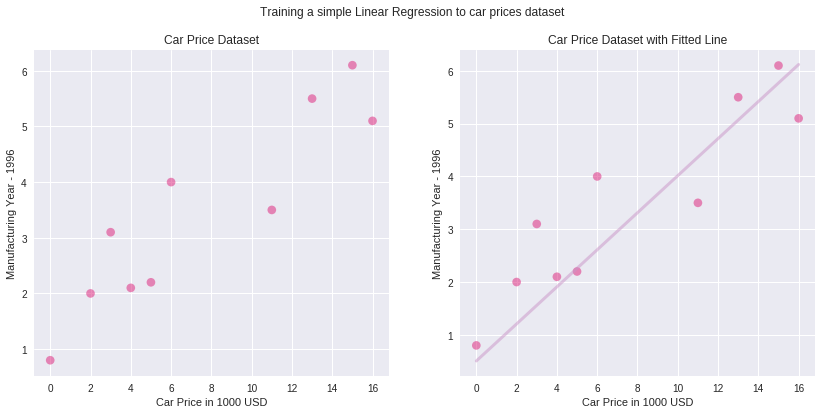

In [3]:
X_train = np.array([2010, 2000, 1999, 2012, 2001, 2002,
                        1997, 2008, 2003, 2013]).reshape((10, 1))
X_train = X_train - X_train.min()
y_train = np.array([5.5, 3.1, 2.0, 6.1, 2.1, 2.2, 0.8, 3.5, 4.0, 5.1])
model = LinearRegression()
model.fit(X_train, y_train)

predicted_points = np.linspace(X_train.min(), X_train.max(), 100) * \
        model.weights[1] + model.weights[0]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(X_train, y_train, s=75, color='#dd1c77', alpha=0.5, edgecolors='none')
axes[0].set_title('Car Price Dataset')
axes[0].set_xlabel('Car Price in 1000 USD')
axes[0].set_ylabel('Manufacturing Year - 1996')

axes[1].scatter(X_train, y_train, s=75, color='#dd1c77', alpha=0.5, edgecolors='none')
axes[1].plot(np.linspace(X_train.min(), X_train.max(), 100),
                 predicted_points, color='#c994c7', linewidth=3, alpha=0.5)
axes[1].set_title('Car Price Dataset with Fitted Line')
axes[1].set_xlabel('Car Price in 1000 USD')
axes[1].set_ylabel('Manufacturing Year - 1996')

fig.suptitle('Training a simple Linear Regression to car prices dataset')
plt.show()

## Summary

In this notebook, we implemented linear regression algorithms form the scratch. We started with necessary assumptions and derived all necessary mathematical formula. Next, we converted those formulae into python code.

## References and Further Reading